## Imports

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'E:\GitHub\smart-parking-system')

from system.detection.model import deeplab_v3
from system.classification.model import CharacterClassifier
import system.backend.utils.utils as utils

## Constants

In [2]:
detection_model_path = r'E:\GitHub\smart-parking-system\system\detection\training\experiment_v0.02\model_checkpoints\v0.02_e59_l0.125.pt'
classification_model_path = r"E:/GitHub/smart-parking-system/system/classification/training/experiment_v0.14/model_checkpoints/v0.14_e9_l0.074.pt"

## Functions

In [3]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(cols), int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [4]:
def plot(img, pred, threshold=0.1):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(torch.squeeze(pred).cpu().numpy()>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

In [5]:
def pred(image, model_segmentare):
    preprocess = transforms.Compose([
        #transforms.Resize((320, 640)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model_segmentare(input_batch)
        return output

In [6]:
def histogram_equalization(image: Image.Image):
    """
    Apply histogram equalization to a given image.
    :param image: An image.
    :return: The image after the histogram equalization as numpy array.
    """
    # Converting the image to grayscale if not in grayscale
    '''if not image.mode == 'L':
        print(f'Image mode is \"{image.mode}\". Converting to grayscale')
        image = image.convert('L')'''

    # Convert the image to an array to be used by skimage equalization function
    image = np.array(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)

    return equalized

## License plate detection

### Load model into memory

In [7]:
model_segmentare = deeplab_v3('resnet101', 'imagenet', ['license-plate'], 'sigmoid')
checkpoint = torch.load(detection_model_path, map_location='cpu')
model_segmentare.load_state_dict(checkpoint)
model_segmentare.eval()

if torch.cuda.is_available():
    model_segmentare.to('cuda')

### Read sample and predict license plate location

In [98]:
input_sample = Image.open(r"E:\GitHub\smart-parking-system\dataset\segmentation\test\images\lpdr_sample_364.jpg").convert('RGB')

In [99]:
input_sample = input_sample.resize((640,320)) # The size required by the model, used for training

preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

input_tensor = preprocess(input_sample)
input_batch = input_tensor.unsqueeze(0)
    
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
    output = model_segmentare(input_batch)

### Crop the license plate from the entire input image

In [100]:
# Convert from tensor to grayscale numpy array
mask = torch.squeeze(output).cpu().numpy()>0.7
mask_grayscale = np.array(Image.fromarray(mask).convert("L"))

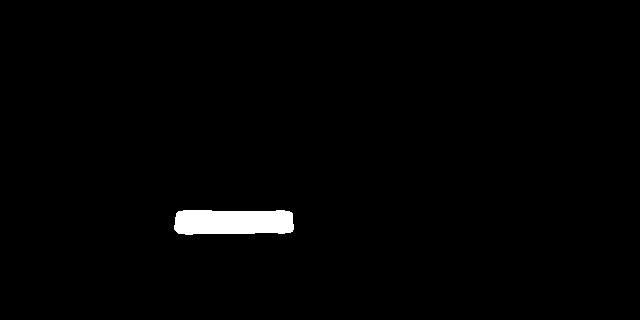

In [101]:
display(Image.fromarray(mask_grayscale))

In [102]:
# Do contour detection to find the biggest bounding box in the predict
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(mask_grayscale, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 127, 255, cv2.THRESH_TOZERO)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [103]:
plate_result = np.array(input_sample)
plate_result = plate_result[max(plate_bbox[0][1], 0) : min(plate_bbox[1][1], plate_result.shape[0]),max(plate_bbox[0][0], 0) : min(plate_bbox[1][0], plate_result.shape[1])]

In [104]:
display(Image.fromarray(plate_result))

In [105]:
plate_result = utils.image_resize(plate_result, height=256)
plate_result = utils.unsharp_mask(plate_result, amount=50)

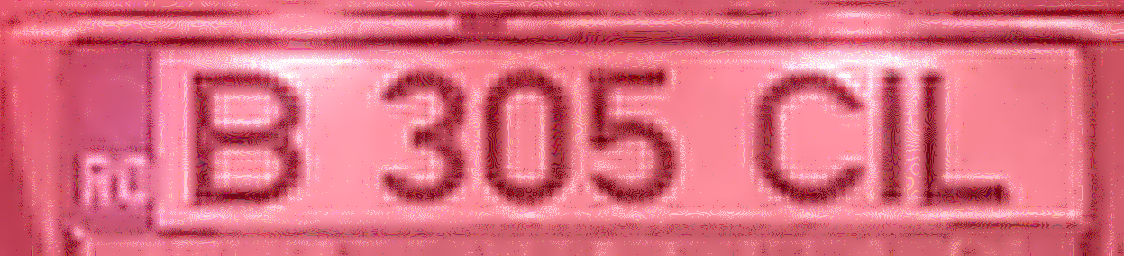

In [106]:
display(Image.fromarray(plate_result))

## Character segmentation using bounding boxes

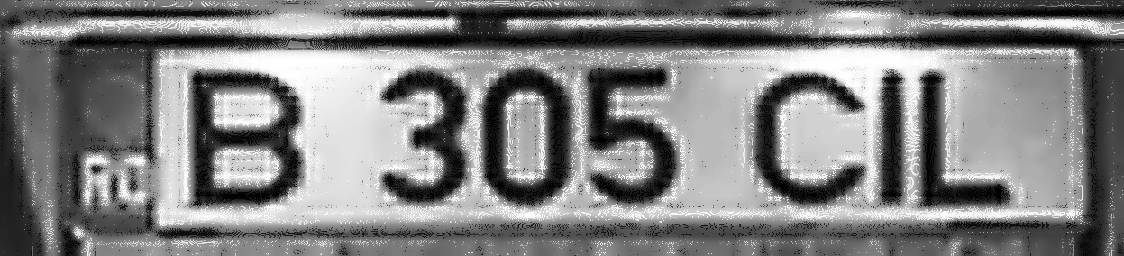

In [107]:
# Do some preprocessing on the license plate
histogram_eq_image = histogram_equalization(plate_result)
display(Image.fromarray(histogram_eq_image))

In [108]:
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(histogram_eq_image, kernel, iterations=1)

_, threshold = cv2.threshold(img_dilation, 150, 255, cv2.THRESH_TOZERO)
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)

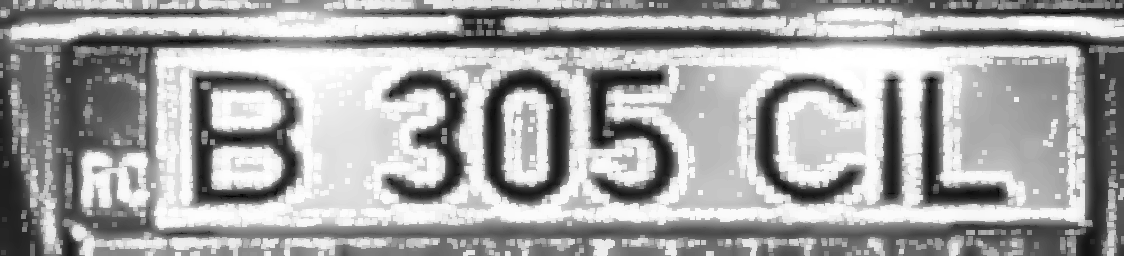

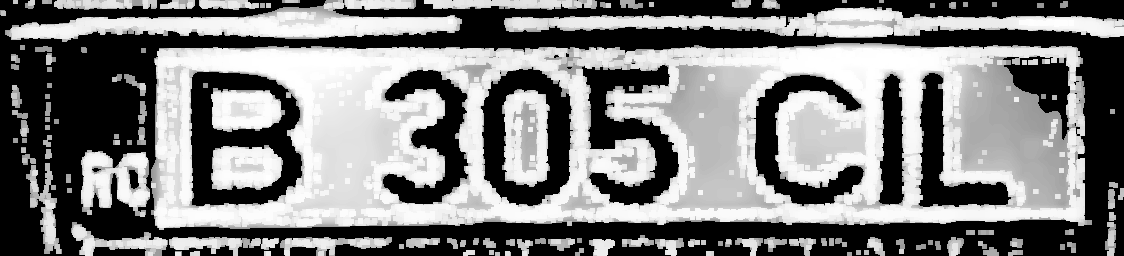

In [109]:
display(Image.fromarray(img_dilation))
display(Image.fromarray(threshold))

In [110]:
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)
x, y = contours[max_area_idx].T
new_plate_bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))

In [111]:
cropped_plate_without_noise = threshold[max(new_plate_bbox[0][1], 0) : min(new_plate_bbox[1][1], threshold.shape[0]),
                                        max(new_plate_bbox[0][0], 0) : min(new_plate_bbox[1][0], threshold.shape[1])]

In [112]:
cropped_plate_without_noise_rgb = cv2.cvtColor(cropped_plate_without_noise,cv2.COLOR_GRAY2RGB) # This is not necessarry in the backend, just for debugging purposes

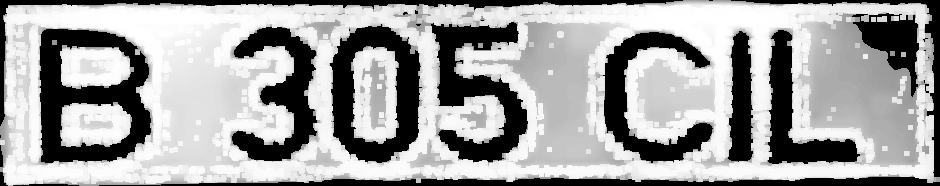

In [113]:
display(Image.fromarray(cropped_plate_without_noise))

In [114]:
contours, _ = cv2.findContours(cropped_plate_without_noise, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(cnt) for cnt in contours]
max_area_idx = np.argmax(areas)

In [115]:
letters_bboxes = [areas.index(x) for x in sorted(areas, reverse=True)[:14]]
letters_bboxes.remove(max_area_idx)
print(f'letters_bboxes after removal is : {letters_bboxes}')

letters_bboxes after removal is : [15, 21, 23, 19, 11, 13, 22, 26, 16, 12, 17, 31, 30]


In [116]:
for idxs in letters_bboxes:
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    backtorgb = cv2.rectangle(cropped_plate_without_noise_rgb, bbox[0], bbox[1], (255, 0, 0), 1)

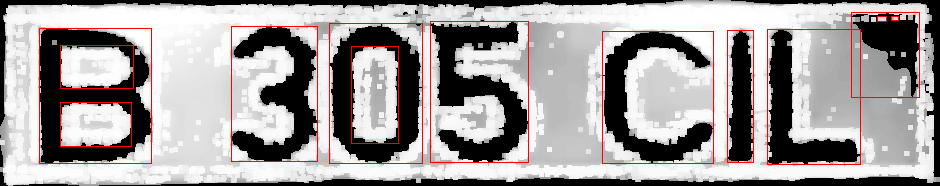

In [117]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

idxs = 15
 values = array([  0, 255], dtype=uint8)
 counts = array([ 7634, 10056], dtype=int64)


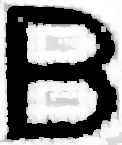

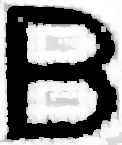

idxs = 21
 values = array([  0, 255], dtype=uint8)
 counts = array([6145, 9305], dtype=int64)


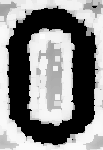

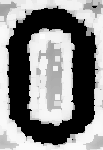

idxs = 23
 values = array([  0, 255], dtype=uint8)
 counts = array([ 5949, 10359], dtype=int64)


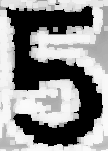

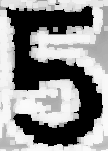

idxs = 19
 values = array([  0, 255], dtype=uint8)
 counts = array([4890, 9030], dtype=int64)


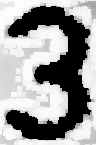

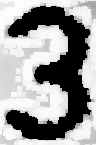

idxs = 11
 values = array([  0, 255], dtype=uint8)
 counts = array([ 4831, 12351], dtype=int64)


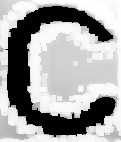

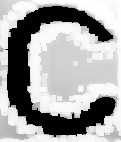

idxs = 13
 values = array([  0, 255], dtype=uint8)
 counts = array([ 4118, 10817], dtype=int64)


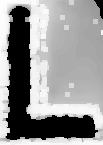

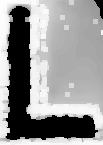

idxs = 22
 values = array([  0, 255], dtype=uint8)
 counts = array([2150, 3949], dtype=int64)


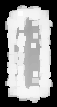

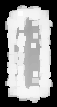

idxs = 26
 values = array([  0, 255], dtype=uint8)
 counts = array([2371, 5039], dtype=int64)


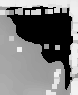

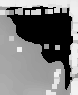

idxs = 16
 values = array([  0, 255], dtype=uint8)
 counts = array([1648, 2726], dtype=int64)


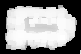

idxs = 12
 values = array([  0, 255], dtype=uint8)
 counts = array([2438, 2674], dtype=int64)


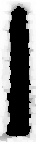

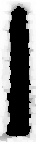

idxs = 17
 values = array([  0, 255], dtype=uint8)
 counts = array([1703, 2696], dtype=int64)


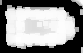

idxs = 31
 values = array([  0, 255], dtype=uint8)
 counts = array([150, 135], dtype=int64)


idxs = 30
 values = array([  0, 255], dtype=uint8)
 counts = array([123, 115], dtype=int64)


In [126]:
filtered_bboxes = []
for idxs in letters_bboxes:
    print(f'{idxs = }')
    x, y = contours[idxs].T
    bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
    character = cropped_plate_without_noise[max(bbox[0][1]-5, 0) : min(bbox[1][1]+5, cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0]-5, 0) : min(bbox[1][0]+5, cropped_plate_without_noise.shape[1])]
    
    _, thresholded_character = cv2.threshold(character, 127, 255, cv2.THRESH_BINARY)
    values, counts = np.unique(thresholded_character, return_counts=True)
    print(f' {values = }')
    print(f' {counts = }')
    display(Image.fromarray(character))
    if counts[0] > 2000 and counts[1] > (counts[0] / 2) and len(counts) > 1:
        display(Image.fromarray(character))
        filtered_bboxes.append(bbox)

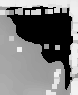

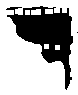

(array([  0, 255], dtype=uint8), array([2371, 5039], dtype=int64))

In [127]:
x, y = contours[26].T
bbox = ((np.min(x), np.min(y)), (np.max(x), np.max(y)))
character = cropped_plate_without_noise[max(bbox[0][1]-5, 0) : min(bbox[1][1]+5, cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0]-5, 0) : min(bbox[1][0]+5, cropped_plate_without_noise.shape[1])]
display(Image.fromarray(character))
_, thresholded_character = cv2.threshold(character, 127, 255, cv2.THRESH_BINARY)
display(Image.fromarray(thresholded_character))
values, counts = np.unique(thresholded_character, return_counts=True)
values, counts

In [129]:
areas[12]

2587.0

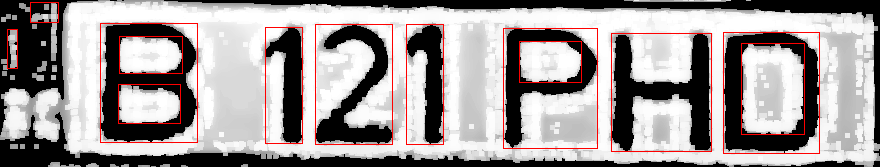

In [76]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [77]:
filtered_bboxes[0][0]

(723, 32)

In [78]:
cropped_plate_without_noise_rgb = cv2.circle(cropped_plate_without_noise_rgb, filtered_bboxes[0][0], radius=3, color=(0, 255, 255), thickness=-1)

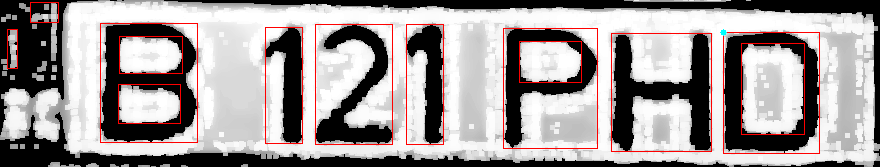

In [79]:
display(Image.fromarray(cropped_plate_without_noise_rgb))

In [80]:
filtered_bboxes

[((723, 32), (819, 153)),
 ((100, 23), (197, 142)),
 ((503, 28), (597, 148)),
 ((611, 33), (711, 151)),
 ((315, 24), (392, 144)),
 ((265, 27), (302, 143)),
 ((406, 24), (443, 144))]

In [81]:
filtered_bboxes = sorted(filtered_bboxes, key=lambda x: x[0][0])

In [82]:
filtered_bboxes

[((100, 23), (197, 142)),
 ((265, 27), (302, 143)),
 ((315, 24), (392, 144)),
 ((406, 24), (443, 144)),
 ((503, 28), (597, 148)),
 ((611, 33), (711, 151)),
 ((723, 32), (819, 153))]

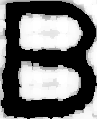

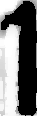

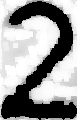

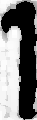

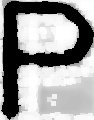

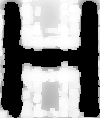

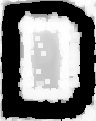

In [83]:
for bbox in filtered_bboxes:
    display(Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                     max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])]))

## Character classification based on bounding boxes

In [84]:
model_classificare = CharacterClassifier().to("cuda")
model_classificare.load_state_dict(torch.load(classification_model_path))
model_classificare.eval()

CharacterClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=196608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=35, bias=True)
)

In [85]:
raw_max_size = [195, 256]

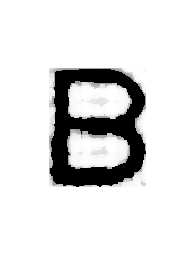

tensor([[-10.0507, -28.6239, -17.6239, -13.5755, -16.9943, -25.7561, -10.3003,
         -26.9788,   0.6279,  -9.7802,  -9.1982,  14.3621, -35.6787,  -6.2087,
          -8.3517, -17.3217,  -7.0212, -17.1182, -26.8403, -24.5986, -19.9561,
         -26.3878, -17.2506,  -8.9662, -18.7616,  -9.4631, -12.1163, -12.0004,
         -33.5404, -15.2706, -25.5515, -11.3126, -25.2075, -30.9638, -16.6443]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([11])


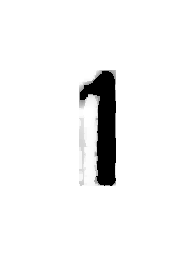

tensor([[ -7.5305,  13.1126, -19.4487,  -0.9483, -17.0659, -15.7982, -21.6277,
         -20.3305,  -9.8103,  -8.9365, -10.5594, -29.2322, -28.4110, -19.4379,
         -34.5989, -29.7150, -18.7838, -23.2914,  -6.3638, -13.4353, -24.3015,
         -26.8039, -18.9220, -19.9080, -17.8376, -25.0258, -17.1611, -19.0073,
          -3.3943, -25.5527, -21.9155, -22.7086, -13.9446, -15.9368, -19.3712]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1])


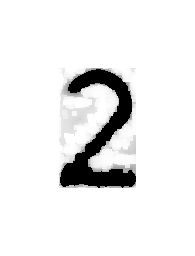

tensor([[-10.4384, -12.7818,  15.0103,   7.7097, -18.5346, -27.1339, -33.9347,
          -5.7228,  -9.3162,  -3.9167, -14.4690, -13.1342, -27.6149, -13.4576,
         -17.2827, -20.9447, -11.8377, -45.1262, -29.3939, -12.0516, -30.4516,
         -37.1690, -25.2625, -35.4842,  -9.2490, -20.4090, -16.0865, -11.6373,
         -14.4585, -27.7593, -17.4844, -28.3978,  -6.9457, -22.1079,  -3.2843]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([2])


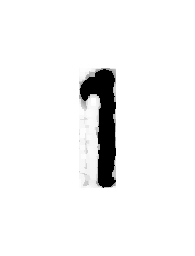

tensor([[ -5.8748,  15.4587, -18.7254,   0.5129, -17.6081, -17.5713, -22.3792,
         -20.9806, -11.2697,  -8.7896, -12.5644, -29.5155, -26.1803, -18.2640,
         -38.3899, -33.2059, -17.5815, -27.1988,  -6.6827, -14.0071, -29.0230,
         -28.8940, -23.0282, -22.0135, -16.1278, -26.3774, -17.6932, -20.1803,
          -3.8069, -28.4499, -24.9892, -24.8434, -16.7918, -19.2548, -21.0031]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1])


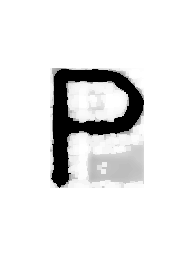

tensor([[-13.8931, -40.5012, -32.0086, -42.4946, -33.1789, -49.5339, -37.7054,
          -9.6694, -10.5458, -26.0760, -21.2887,  -5.0279, -54.7585, -25.4211,
         -15.8491,  -1.2198, -29.0040,  -4.7829, -32.7829, -48.1066, -20.9012,
         -38.4363,  -6.0044, -24.8930, -36.6944,  22.5130,   1.6081, -36.6457,
         -40.0607, -18.5995, -22.6429,  -9.4560, -30.5937, -16.2719, -26.1724]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([25])


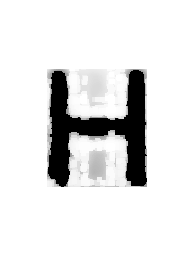

tensor([[-16.8059, -45.2077, -61.8803, -43.7263, -38.9448, -57.3589, -31.9421,
         -42.1767, -14.1209, -31.8961, -22.6660,   1.4326, -77.3168, -27.9370,
         -38.3155, -23.0667, -14.5403,  24.0622, -33.6157, -31.4511, -10.0296,
         -36.7322,   6.8832,   3.5789, -48.7221,  -6.9887,   0.4280, -38.1944,
         -72.4490,  -8.7284, -20.1536,  -9.5148, -45.3458, -34.7262, -48.8613]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([17])


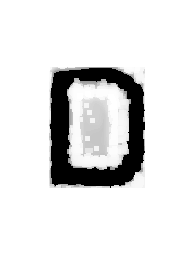

tensor([[ -3.7719, -22.8677, -15.2318, -23.3187, -19.9672, -39.3424, -25.7337,
         -24.0185, -29.4891, -27.7426, -19.7320,  -1.8534, -14.9963,  13.4714,
         -24.0573, -32.6356, -14.0584, -27.5617, -28.0487, -16.5484, -36.7496,
         -11.2010, -34.1320, -10.4508,   5.8620, -17.4808, -23.1906, -28.4381,
         -35.9054,  -5.3822, -19.9231, -27.5909, -43.4886, -44.2674, -19.8042]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([13])


In [86]:
license_plate_predicts_list = []
for bbox in filtered_bboxes:
    character = Image.fromarray(cropped_plate_without_noise[max(bbox[0][1], 0) : min(bbox[1][1], cropped_plate_without_noise.shape[0]), 
                                            max(bbox[0][0], 0) : min(bbox[1][0], cropped_plate_without_noise.shape[1])])
    width, height = character.size

    x_axis_offset = (raw_max_size[0] - width) / 2
    y_axis_offset = (raw_max_size[1] - height) / 2
    new_width = width + int((2 * x_axis_offset))
    new_height = height + int((2 * y_axis_offset))

    result = Image.new(character.mode, (new_width, new_height), 255)
    result.paste(character, (int(x_axis_offset), int(y_axis_offset)))
    display(result)
    transform = transforms.Compose([transforms.ToTensor()])
    
    result = transform(result)
    result = result.unsqueeze(0)
    prediction = model_classificare(result.cuda())
    print(prediction)
    print(torch.argmax(prediction.cpu(), axis=1))
    license_plate_predicts_list.append(torch.argmax(prediction.cpu(), axis=1))

## License plate reconstruction as string

In [87]:
characters_mapping = {"0": 0,
                      "1": 1,
                      "2": 2,
                      "3": 3,
                      "4": 4,
                      "5": 5,
                      "6": 6,
                      "7": 7,
                      "8": 8,
                      "9": 9,
                      "10": "A",
                      "11": "B",
                      "12": "C",
                      "13": "D",
                      "14": "E",
                      "15": "F",
                      "16": "G",
                      "17": "H",
                      "18": "I",
                      "19": "J",
                      "20": "K",
                      "21": "L",
                      "22": "M",
                      "23": "N",
                      "24": "O",
                      "25": "P",
                      "26": "R",
                      "27": "S",
                      "28": "T",
                      "29": "U",
                      "30": "V",
                      "31": "W",
                      "32": "X",
                      "33": "Y",
                      "34": "Z"}
                    
                      

In [88]:
int(license_plate_predicts_list[0][0])

11

In [89]:
license_plate_as_string = []
for character in license_plate_predicts_list:
    license_plate_as_string.append(characters_mapping[str(int(character[0]))])

In [90]:
license_plate_as_string

['B', 1, 2, 1, 'P', 'H', 'D']

In [130]:
type(license_plate_predicts_list[0])

torch.Tensor